### Obtención de datos externos

In [1]:
### Número de hipotecas

import requests
import time
import pprint
import pickle
import numpy as np
import json
import pandas as pd
pd.set_option('display.float_format', lambda x: '{:.3f}'.format(x)) #Limiting floats output to 3 decimal points
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
import matplotlib.pyplot as plt
from matplotlib import pyplot
from collections import Counter
from wordcloud import WordCloud
import xml.etree.ElementTree as ET
import re
from unicodedata import normalize
from sklearn import linear_model
from sklearn import metrics
from sklearn.preprocessing import PolynomialFeatures
from matplotlib import pyplot
import seaborn as sns
sns.set(style="ticks", color_codes=True, font_scale=1.5)
color = sns.color_palette()
sns.set_style('darkgrid')
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from pandas_summary import DataFrameSummary
%matplotlib
%pylab inline
pylab.rcParams['figure.figsize'] = (20, 10)
import os
import warnings
warnings.simplefilter(action = 'ignore', category=FutureWarning)
warnings.filterwarnings('ignore')
def ignore_warn(*args, **kwargs):
    pass
warnings.warn = ignore_warn #ignore annoying warning (from sklearn and seaborn)
import seaborn as sns
sns.set(style="ticks", color_codes=True, font_scale=1.5)
color = sns.color_palette()
sns.set_style('darkgrid')
import mpl_toolkits
from mpl_toolkits.mplot3d import Axes3D
import pylab 
from scipy import stats
from scipy.stats import skew, norm, probplot, boxcox
from scipy.special import boxcox1p
from patsy import dmatrices
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import RobustScaler, PolynomialFeatures, StandardScaler, LabelEncoder
from sklearn.feature_selection import f_regression, mutual_info_regression, SelectKBest, RFECV, SelectFromModel
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs
from sklearn.feature_extraction import FeatureHasher
from sklearn.decomposition import PCA, KernelPCA
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.kernel_ridge import KernelRidge
from sklearn.linear_model import LinearRegression, OrthogonalMatchingPursuit, Lasso, LassoLarsIC, ElasticNet, ElasticNetCV
from sklearn.linear_model import SGDRegressor, PassiveAggressiveRegressor, HuberRegressor, BayesianRidge
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor, BaggingRegressor, ExtraTreesRegressor
import xgboost as xgb
from xgboost import XGBRegressor, plot_importance
import lightgbm as lgb
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV, cross_val_score, KFold, cross_val_predict, train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score


def troceador_calles_api(street):
    words_street = []
    words_in_street = street.split(' ')
    for word in words_in_street:
        words = word.split(',')
        for w in words:
            if '/' in w:
                words.extend(w.split('/'))
        for w in words:
            if len(w) > 2 and w.upper() != 'DEL':
                words_street.append(w)
    return words_street
          
def comparador(streets_api, street_to_find):
    words_street_to_find = troceador_calles_api(street_to_find)
    streets = []
    for street in streets_api:
        words_street_api = troceador_calles_api(street)
        coincidences = 0
        for w1 in words_street_api:
            w1 = normalizador(w1)
            len_w1 = len(w1)
            coincidences_words = 0
            for w2 in words_street_to_find:
                w2 = normalizador(w2)
                if len_w1-1 < len(w2) < len_w1+1:
                    if w2 in w1:
                        coincidences_words += 1
            coincidences += coincidences_words
        if coincidences == len(words_street_to_find) and coincidences != 0:
            streets.append(street)
        elif coincidences >= max(int((len(words_street_api)+1)/2), int((len(words_street_to_find)+1)/2)):
            streets.append(street)
    
    if len(streets)==1:
        return streets[0]
    else:
        if len(set(streets))==1:
            return streets[0]
        else:
            for street in streets:
                if normalizador(street) in normalizador(street_to_find):
                    return street
            return False
        
def normalizador(string):
    string = re.sub(
        r"([^n\u0300-\u036f]|n(?!\u0303(?![\u0300-\u036f])))[\u0300-\u036f]+", r"\1", 
        normalize( "NFD", str(string)), 0, re.I
    )
    string = string.lower()
    return normalize( 'NFC', string)

def parseo_fecha_cuatrimeste(row):
    if row[1] == 'Primero':
        date = '01/01/'
    elif row[1] == 'Segundo':
        date = '01/04/'
    elif row[1] == 'Tercero':
        date = '01/07/'
    elif row[1] == 'Cuarto':
        date = '01/10/'
    return date+str(row[0])




Using matplotlib backend: Qt5Agg
Populating the interactive namespace from numpy and matplotlib


### Modelo de regresión lineal

In [2]:
tablin = pd.read_csv(r'C:\Users\Marta\Desktop\Rotación 2 SBD\BackUp_Proyecto\Python Scripts\Modelo evolución precios\Datos - copia - Marta\tabla.csv', 
                   sep=';', engine="python", decimal=',', encoding="latin1")

#predict = regresión lineal x imptotal
#predict_act = regresión lineal x imp total actualizado

#Crear variables dummies 
hi= tablin.loc[:,['UBICACION_MUNICIPIO_DESC',
'UBICACION_ZONA_COD','UBICACION_INMUEBLE_COD']]
dummy = pd.get_dummies(hi)
tablin = pd.concat([tablin, dummy], axis=1)
tablin = tablin.drop(['UBICACION_MUNICIPIO_DESC',
'UBICACION_ZONA_COD','UBICACION_INMUEBLE_COD'], axis=1)

#'Municipio'

tablin=pd.DataFrame(tablin)
#Recodificar
tablin= tablin.replace('SI', '1')
tablin= tablin.replace('NO', '0')
tablin= tablin.replace('LIBRE', 'Libre' )
tablin= tablin.replace('ESPECIAL', 'Especial')

tablin= tablin.drop(columns=['Fecha','MATRICULA'])
tablin['VIV_SUPERF_TERRAZA']= [1 if x>0 else x for x in (tablin['VIV_SUPERF_TERRAZA'])] #codificar: tiene terraza o no

continuous_cols= ['VIV_SUPERF_TERRAZA','SUPERF_ADOPTADA', 'Hipotecas_log','Tasa desempleo_log','change']

features = tablin[continuous_cols]
scaler = StandardScaler().fit(features.values)
features = scaler.transform(features.values)
tablin[continuous_cols] = features

In [6]:
ind= tablin.drop(['IMPTOTAL','Municipio','MES', 'AÑO'],axis=1)
x= np.asarray(ind)
x = x.reshape((len(x), -1))
y = tablin.IMPTOTAL

In [7]:
x_train, x_test, y_train, y_test = train_test_split(x,y, random_state=33)

In [ ]:
from sklearn.svm import SVR
from sklearn.feature_selection import RFE

# Create the RFE object and rank each pixel
linear_regressor = SVR(kernel="linear")
rfe = RFE(estimator=linear_regressor, n_features_to_select=10, step=1)


In [ ]:
from sklearn.svm import SVR
from sklearn.feature_selection import RFE

# Create the RFE object and rank each pixel
linear_regressor = SVR(kernel="linear")
rfe = RFE(estimator=linear_regressor, n_features_to_select=10, step=1)


Text(0,0.5,'Predictions')

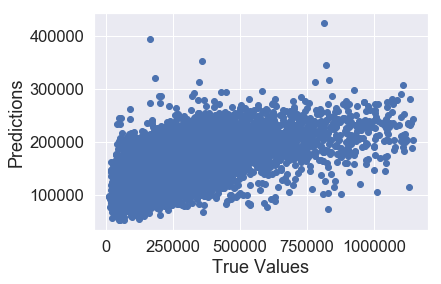

In [11]:
lm= linear_regressor.fit(x_train,y_train)
predictions = lm.predict(x_test)
## The line / model
plt.scatter(y_test, predictions)
plt.xlabel("True Values")
plt.ylabel("Predictions")
lm.score(x_test, y_test)

In [28]:
from sklearn.feature_selection import RFECV
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_predict, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline



clf = SVR(kernel="linear")

estimators = [('rfecv', RFECV(estimator=clf, scoring='accuracy'))]

# create pipeline
pipeline = Pipeline(estimators)

# fit rfecv to data
rfecv_data = pipeline.named_steps['rfecv'].fit(x, y)

# get the feature ranking
ranking_features = rfecv_data.ranking_
print (ranking_features)


ValueError: continuous is not supported

In [12]:
from sklearn.svm import SVR
from sklearn.feature_selection import RFE

# Create the RFE object and rank each pixel
linear_regressor = SVR(kernel="linear")
rfe = RFE(estimator=linear_regressor, n_features_to_select=10, step=1)


lm= linear_regressor.fit(x_train,y_train)
predictions = lm.predict(x_test)
## The line / model
plt.scatter(y_test, predictions)
plt.xlabel("True Values")
plt.ylabel("Predictions")
lm.score(x_test, y_test)  #accuracy

0.14430047582002037

In [19]:
a=[]
for munic in tablin.Municipio.unique():

    data_test_regression = tablin[tablin.Municipio==munic]
    data_test_regression['Indice_Fecha'] = range(len(data_test_regression))
    

    linear_regressor.fit(x,y)
    
    ranking = rfe.ranking_.reshape(X_[0].shape)
    predictions = linear_regressor.predict(X_pred)
    model= linear_regressor.score(X_, yt)

    pyplot.title( "Municipio: %s" % munic )
    plot1 = pyplot.plot( xt, yt, c='g' )
    plot2 = pyplot.plot( xt_pred, predictions, c='m' )
    
    list_predictions = [item for sublist in predictions for item in sublist]
    tablin.loc[tablin.Municipio==munic, 'BSpreu'] = list_predictions
    
    a.append(model)

    pyplot.show()

ValueError: could not convert string to float: '2016-10-01'

In [4]:
sum(a)/len(a) 

0.9274563042178448

## Nuevos

In [8]:
nuevos = pd.read_csv(r'C:\Users\Marta\Desktop\Rotación 2 SBD\BackUp_Proyecto\Python Scripts\Actualizacion.csv', 
                   sep=';', engine="python", encoding="latin1")
nuevos= nuevos[nuevos['TIPOBIEN']=='VIVIE']

In [9]:
nuevos=nuevos.loc[:,['REF_FINCA_ENTIDAD', 'VAL_VALOR_TASACION']]
nuevos.columns=['MATRICULA', 'VALOR_ULT_TASACION']

In [10]:
tablin= tablin.merge(nuevos)

In [11]:
actual= tablin['VALOR_ULT_TASACION']
forecast= tablin['BSpreu']

tablin['Error_MAPE']= round(np.abs(forecast - actual)/np.abs(actual),2)*100

tablin['Error_RMSE']=round(((forecast - actual)**2)**.5)  # RMSE

In [12]:
nuevos = pd.read_csv(r'C:\Users\Marta\Desktop\Rotación 2 SBD\BackUp_Proyecto\Python Scripts\Actualizacion.csv', 
                   sep=';', engine="python", encoding="latin1")
nuevos= nuevos[nuevos['TIPOBIEN']=='VIVIE']

nuevos=nuevos.loc[:,['REF_FINCA_ENTIDAD', 'VAL_VALOR_TASACION']]
nuevos.columns=['MATRICULA', 'VALOR_ULT_TASACION']

tablin['Inclosa']= '1'
comparacion_precioactual_nuevosdatos= nuevos.merge(tablin, how='left')

In [13]:
comparacion_precioactual_nuevosdatos= comparacion_precioactual_nuevosdatos.loc[:,['MATRICULA', 'VALOR_ULT_TASACION','BSpreu','Error_MAPE','Error_RMSE']]

In [15]:
# Accuracy metrics
def metricas(forecast, actual):
    actual_min= actual.min()
    actual_max= actual.max()
    forecast_min= forecast.min()
    forecast_max= forecast.max()
    mape = round(np.mean(np.abs(forecast - actual)/np.abs(actual)),2)  # MAPE
    rmse = round(np.mean((forecast - actual)**2)**.5,2)  # RMSE
    mean = round(np.mean(forecast),2)  # RMSE
    corr = tablin[['VALOR_ULT_TASACION', 'BSpreu']].corr()
    cov = tablin[['VALOR_ULT_TASACION', 'BSpreu']].cov()
    var1= round(actual.var(),2)
    var2= round(forecast.var(),2)
    std1= round(actual.std(),2)
    std2= round(forecast.std(),2)
    return({'forecast_min': forecast_min, 'forecast_max':forecast_max,
           'actual_min':actual_min, 'actual_max':actual_max,
            'MAPE':mape,'RMSE':rmse, 'Media de las predicciones':mean,
            'Correlación':corr,
             'Covarianza': cov,
           'Varianza_IMPTOTAL': var1, 'Varianza_BSpreu':var2,
           'SD_IMPTOTAL': std1, 'SD_BSpreu':std2})

metricas(forecast,actual)

{'forecast_min': -268160.0,
 'forecast_max': 1193984.0,
 'actual_min': 23068.74,
 'actual_max': 1202651.17,
 'MAPE': 0.23,
 'RMSE': 96859.89,
 'Media de las predicciones': 260749.69,
 'Correlación':                     VALOR_ULT_TASACION  BSpreu
 VALOR_ULT_TASACION               1.000   0.874
 BSpreu                           0.874   1.000,
 'Covarianza':                     VALOR_ULT_TASACION          BSpreu
 VALOR_ULT_TASACION     37779427580.502 32097327992.568
 BSpreu                 32097327992.568 35738891358.816,
 'Varianza_IMPTOTAL': 37779427580.5,
 'Varianza_BSpreu': 35738891358.82,
 'SD_IMPTOTAL': 194369.31,
 'SD_BSpreu': 189047.33}